## Простой эксперимент

### Вводные данные

In [122]:
import datetime as dt
import pytz

MSK = pytz.timezone('Europe/Moscow')

AD_START_TIME = dt.datetime(2021, 11, 10, 12, tzinfo=MSK)
AD_START_TIME.isoformat()

MIN_CLICKS_PER_HOUR = 800
MAX_CLICKS_PER_HOUR = 1200

AD_TOTAL_DAYS = 5
AD_ACTIVE_HOURS_PER_DAY = 24

EXIT_PROBABILITY = .001

MAX_STEPS = 50
MIN_SECONDS_BETWEEN_STEPS = 5
MAX_SECONDS_BETWEEN_STEPS = 60 * 60  # 60 minutes
MEAN_SECONDS_BETWEEN_STEPS = 60  # 60 seconds
STD_SECONDS_BETWEEN_STEPS = 30  # 30 seconds

def print_inputs():
    print(
        f'Параметры эксперимента:\n\n'
        f'Старт рекламы: {AD_START_TIME}\n'
        f'Продолжительность рекламы: {AD_TOTAL_DAYS} дней\n'
        f'Реклама активна в течение каждого дня: {AD_ACTIVE_HOURS_PER_DAY} часов\n'
        f'Количество кликов по рекламе в час (минимум): {MIN_CLICKS_PER_HOUR}\n'
        f'Количество кликов по рекламе в час (максимум): {MAX_CLICKS_PER_HOUR}\n'
        f'Вероятность, что клиент уйдет (действует на каждом шаге): {EXIT_PROBABILITY:.2%}\n'
        f'Сколько шагов проходит каждый клиент (максимум): {MAX_STEPS}\n'
        f'Время между шагами (среднее): {MEAN_SECONDS_BETWEEN_STEPS}\n'
        f'Время между шагами (стандартное отклонение): {STD_SECONDS_BETWEEN_STEPS}\n'
    )

print_inputs()

Параметры эксперимента:

Старт рекламы: 2021-11-10 12:00:00+02:30
Продолжительность рекламы: 5 дней
Реклама активна в течение каждого дня: 24 часов
Количество кликов по рекламе в час (минимум): 800
Количество кликов по рекламе в час (максимум): 1200
Вероятность, что клиент уйдет (действует на каждом шаге): 0.10%
Сколько шагов проходит каждый клиент (максимум): 50
Время между шагами (среднее): 60
Время между шагами (стандартное отклонение): 30



### Симуляция

In [94]:
import pandas as pd
import random

requests = []
total_clients = 0
for day in range(AD_TOTAL_DAYS):
    for hour in range(AD_ACTIVE_HOURS_PER_DAY):
        clicks_in_this_hour = random.uniform(MIN_CLICKS_PER_HOUR, MAX_CLICKS_PER_HOUR)
        start_time = AD_START_TIME + dt.timedelta(days=day, hours=hour)
        for click_no in range(int(clicks_in_this_hour)):
            client_id = f'{day}:{hour}:{click_no}'
            total_clients += 1
            start_time = AD_START_TIME + dt.timedelta(days=day, hours=hour + random.uniform(0, 1))
            request_time = start_time
            for step in range(MAX_STEPS):
                requests.append({
                    'time': request_time,
                    'client': client_id,
                })
                client_leaves_now = random.uniform(0, 1) <= EXIT_PROBABILITY
                if client_leaves_now:
                    break

                request_time += dt.timedelta(seconds=max(.0, random.gauss(MEAN_SECONDS_BETWEEN_STEPS, STD_SECONDS_BETWEEN_STEPS)))

In [95]:
requests_df = pd.DataFrame.from_records(requests, index='time')

In [96]:
requests_df.head()

,client
time,
2021-11-10 12:37:00.030460+03:00,0:0:0
2021-11-10 12:38:04.011999+03:00,0:0:0
2021-11-10 12:39:04.992183+03:00,0:0:0
2021-11-10 12:39:48.959445+03:00,0:0:0
2021-11-10 12:41:23.510351+03:00,0:0:0


In [114]:
df = requests_df.copy()
df['requests'] = 1
df.drop(columns='client', inplace=True)
df.sort_index(inplace=True)
df = df.resample('S').sum()
df

,requests
time,
2021-11-10 12:30:04+03:00,1
2021-11-10 12:30:05+03:00,1
2021-11-10 12:30:06+03:00,1
2021-11-10 12:30:07+03:00,0
2021-11-10 12:30:08+03:00,0
...,...
2021-11-15 13:25:03+03:00,0
2021-11-15 13:25:04+03:00,0
2021-11-15 13:25:05+03:00,0


### Результаты

<AxesSubplot:xlabel='time'>

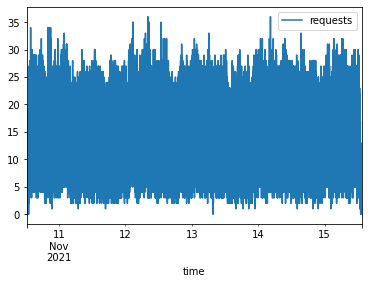

In [115]:
df.plot()

In [119]:
def print_results():
    print(
        'Статистика:\n\n'
        'Запросов в секунду:\n'
        f'  Максимум: {df.requests.max()}\n'
        f'  Минимум: {df.requests.min()}\n'
        f'  В среднем: {df.requests.mean():.2f}\n\n'
        f'Всего клиентов: {total_clients}\n'
    )

print_results()

Статистика:

Запросов в секунду:
  Максимум: 36
  Минимум: 0
  В среднем: 13.45

Всего клиентов: 120014



In [120]:
print_inputs()

Старт рекламы: 2021-11-10 12:00:00+02:30
Продолжительность рекламы: 5 дней
Реклама активна в течение каждого дня: 24 часов
Количество кликов по рекламе в час (минимум): 800
Количество кликов по рекламе в час (максимум): 1200
Вероятность, что клиент уйдет (действует на каждом шаге): 0.10%
Сколько шагов проходит каждый клиент (максимум): 50
Время между шагами (среднее): 60
Время между шагами (стандартное отклонение): 30

